In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths

storage = paths.storage.Storage("_toy_retis.nc", "r")

In [2]:
len(storage.samplesets)

201

In [3]:
retis = storage.transitions.load(0)
sset0 = storage.samplesets[0]

In [10]:
trace_1 = paths.trace_ensembles_for_replica(4, storage)
trace_readable = [sset0[e].replica for e in trace_1]

In [11]:
trace_2 = paths.trace_replicas_for_ensemble(retis.ensembles[0], storage)

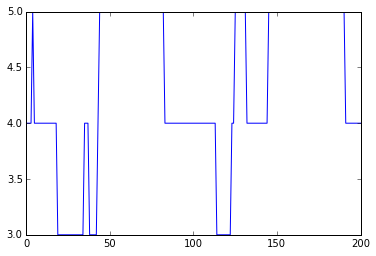

In [12]:
plt.plot(trace_readable)

In [8]:
repx_net = paths.ReplicaNetwork(storage=storage)

In [19]:
top=5
bottom=3
trace = paths.condense_repeats(trace_readable)

In [20]:
print trace

[(4, 4), (5, 1), (4, 14), (3, 16), (4, 3), (3, 5), (4, 1), (5, 39), (4, 31), (3, 9), (4, 2), (5, 7), (4, 13), (5, 46)]


In [32]:
down_trips = []
up_trips = []
round_trips = []
direction = None
trip_counter = 0
first_direction = None
for (loc, count) in trace:
    if loc == top and direction != +1:
        direction = +1
        if trip_counter > 0:
            up_trips.append(trip_counter)
        trip_counter = 0
    elif loc == bottom and direction != -1:
        direction = -1
        if trip_counter > 0:
            down_trips.append(trip_counter)
        trip_counter = 0
    if direction is not None:
        if first_direction is None:
            first_direction = direction
        trip_counter += count

if first_direction == 1:
    rt_pairs = zip(down_trips, up_trips)
elif first_direction == -1:
    rt_pairs = zip(up_trips, down_trips)
else:
    raise RuntimeWarning("No first direction identified: Are there no 1-way trips?")
round_trips = [sum(pair) for pair in rt_pairs]

In [33]:
down_trips, up_trips, round_trips

([15, 70], [25, 11], [40, 81])